# Multivariate Kernel Example
Spring 2019 AME-70790 Final Project

Nicholas Geneva (ngeneva@nd.edu)

Reference: Wand, M. P., & Jones, M. C. (1994). Kernel smoothing. Chapman and Hall/CRC.
___
Thus far we have focused on how kernel methods can be used to provide density estimates of one dimensional data.
Following a similar form of the 1D case, the d-dimensional kernel density estimator is defined at follows:
    $$f(\textbf{x},H)=n^{-1}\sum_{i=1}^{b}K_{H}(\textbf{x}-\textbf{x}_{i}), \quad K_{H}(\textbf{x})=|H|^{1/2}K(H^{-1/2}\textbf{x}),$$
where $H$ is a symmetric positive definite $d\times d$ matrix referred to as the *bandwidth matrix*.
Note that the kernel function $K$ must stills satisfy the normalization property ($\int K(x)dx = 1$).
The most commonly techniques to generate a multivariate kernel is either using a product kernel or a radially symmetric kernel given by:
    $$ K^{P}(\textbf{x})=\prod_{i=1}^{d} k(x_{i}), \quad K^{S}(\textbf{x})=\frac{k\left\{(\textbf{x}^{T}\textbf{x})^{1/2}\right\}}{\int k\left\{(\textbf{x}^{T}\textbf{x})^{1/2}\right\}},$$
where $k$ is a 1D kernel function.
Its clear that the radially symmetric kernel resembles that of a multivariate Gaussian distribution which happens to be one of the most commonly used multivariate kernels.

Now let us implement a 2D KDE for an arbitrary mixture of Gaussians. We consider a density function with five Gaussian components given as the following:
    $$f(\textbf{x})=\sum_{i=1}^{5}\frac{1}{5}\phi\left(\textbf{x} | \boldsymbol{\mu}_{i}, \Sigma\right), \quad \boldsymbol{\mu}_{i}=\left\{[-0.5,-1],[0,0],[0,1],[1,1.5],[1.5,-0.5]\right\}, \quad \Sigma = \left[\begin{matrix} 0.5 & 0.25 \\ 0.25 & 0.5 \end{matrix}\right].$$
where $\phi(\textbf{x})$ is the normal PDF. We will again use 1000 training data points to approximate this density function with the kernel density estimator.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [15]:
plt.close("all")
np.random.seed(123)
# Create grid
n = 100
X0, Y0 = np.meshgrid(np.linspace(-3, 3, n), np.linspace(-3, 3, n))
X = np.stack([np.reshape(X0, (-1)), np.reshape(Y0, (-1))], axis=1)

# Sample components
c = np.random.randint(1,6,1000)
mu = np.array([[-0.5,-1],[0,0],[0,1],[1,1.5],[1.5,-0.5]])
sigma = np.array([[0.5, 0.25],[0.25, 0.5]])
x_train0 = []
y_target = np.zeros(X.shape[0])
# Sum each component
for i in range(5):
    x0 = np.random.multivariate_normal(mu[i], sigma, np.sum(c==i+1))
    x_train0.append(x0)
    y_target = y_target + 0.2*multivariate_normal.pdf(X, mu[i], sigma)
x_train0 = np.concatenate(x_train0, axis=0)

For our kernel function we will use the standard multivariate Gaussian kernel:
    $$K(\textbf{x})=\mathcal{N}(\textbf{x}|0,H), \quad H=\left[\begin{matrix} 0.1 & 0 \\ 0 & 0.1 \end{matrix}\right].$$

In [17]:
# Expand array dims and repeat
x_pred = np.expand_dims(X, axis=1).repeat(x_train0.shape[0], axis=1)
x_train = np.expand_dims(x_train0, axis=0).repeat(X.shape[0], axis=0)

H = np.array([[0.1,0],[0,0.1]])
y_pred = (1./1000)*np.sum(multivariate_normal.pdf(x_pred-x_train, cov=H), axis=-1)

We note here that we were able to calculate the 2D prediction field in a single batch operation.
However, as the number of training data or prediction points increases, this process would ultimately be too large for this approach and a mini-batch approach would have to be used.
This will be illustrated in the next example.

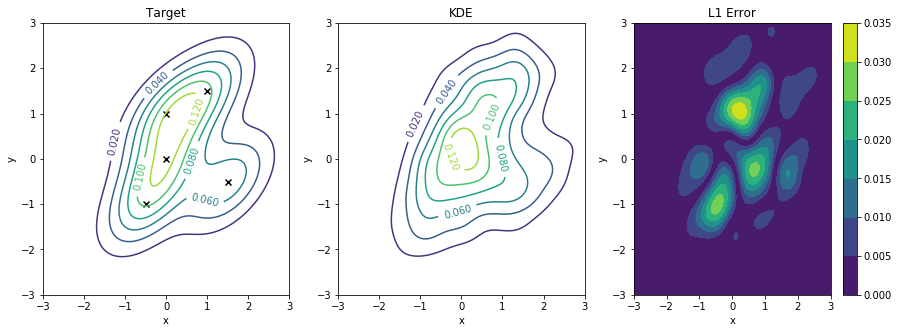

In [39]:
fig = plt.figure(figsize=(15,5))
ax = []
ax.append(plt.subplot2grid((1, 3), (0, 0)))
ax.append(plt.subplot2grid((1, 3), (0, 1)))
ax.append(plt.subplot2grid((1, 3), (0, 2)))

# Plot target densities
x = np.reshape(X[:,0], (n,n))
y = np.reshape(X[:,1], (n,n))
y_target = np.reshape(y_target, (n,n))
CS = ax[0].contour(x, y, y_target)
plt.clabel(CS, inline=1, fontsize=10)

# Plot target components
ax[0].scatter(mu[:,0], mu[:,1], c='k', marker='x')

# Plot predicted density
y_pred = np.reshape(y_pred, (n,n)) 
CS = ax[1].contour(x, y, y_pred)
plt.clabel(CS, inline=1, fontsize=10) 
# Plot training data
# ax[1].scatter(x_train0[:,0], x_train0[:,1], c='k', marker='^', s=3, alpha=0.4)

cs = ax[2].contourf(x, y, np.abs(y_pred - y_target))
fig.colorbar(cs, ax=ax[2])

for ax0 in ax:
    ax0.set_xlim([-3,3])
    ax0.set_ylim([-3,3])
    ax0.set_xlabel('x')
    ax0.set_ylabel('y')

ax[0].set_title('Target')
ax[1].set_title('KDE')
ax[2].set_title('L1 Error')

plt.show()

(Left to right) The target density with each component mean value marked with a black 'x'. The KDE using 1000 training points and the L1 error.
Over all the 2d kernel does a reasonable job recovering the true density.